## Initializations
---

In [1]:
!pip install awswrangler awswrangler[redshift] fuzzywuzzy python-Levenshtein

In [2]:
import json
import re
import time
from datetime import datetime, timedelta, timezone

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import awswrangler as wr
import nltk
from fuzzywuzzy import fuzz, process
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

from IPython.display import display, HTML, Markdown

bold_start = "\033[1m"
bold_end = "\033[0m"

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
# Get today's date
today = datetime.today()
today.date()

datetime.date(2024, 11, 21)

In [4]:
%%time
df_db='bd_ipa_prod'
df_query = '''
SELECT * 
FROM "bd_ipa_prod"."p2p_hum2024_ruthran"
'''
df = wr.athena.read_sql_query(df_query, database=df_db)

CPU times: user 2.9 s, sys: 702 ms, total: 3.6 s
Wall time: 21.4 s


In [5]:
%%time
sql_review = '''
select date_add('minute', -2, review_datecreated) AS review_datecreated,
	date_add('minute', 2, review_datecompleted) AS review_datecompleted,
	servicerequestid as "sr_id",
	review_completedbyname,
	review_reviewtype,
	row_number() over (
		partition by servicerequestid
		order by commitdateinstant
	) "commit",
	review_reviewoutcome,
	review_determinationnote,
	review_decisionreasoning,
	laststate,
	nextstate,
	servicerequest_cohereid,
	review_id,
	case
		when servicerequest_datecreated is null then sr_datecreated else servicerequest_datecreated
	end as "sr_datecreated",
	commitdateinstant,
	servicerequest_clinicalservicename,
	servicerequest_encountertype,
	servicerequest_patientid,
	servicerequest_patient_coverage_healthplanname
from "tableau"."review_production"
where review_reviewstatus = 'COMPLETE'
	and servicerequest_datecreated >= date('2024-05-01')
	and servicerequest_patient_coverage_healthplanname = 'Humana'
order by 3, commitdateinstant
'''
reviewdf = wr.athena.read_sql_query(sql_review, database=df_db)
reviewdf.shape

CPU times: user 4.21 s, sys: 1.54 s, total: 5.76 s
Wall time: 9.87 s


(507044, 19)

In [6]:
%%time
pp_query = '''
with review as (
	select date_add('minute', -2, review_datecreated) AS review_datecreated,
		date_add('minute', 2, review_datecompleted) AS review_datecompleted,
		servicerequestid as "sr_id",
		review_completedbyname,
		row_number() over (
			partition by servicerequestid
			order by commitdateinstant
		) "p2p_commit",
		servicerequest_patient_coverage_healthplanname,
		commitdateinstant,
		review_determinationnote,
		review_reviewoutcome,
		laststate,
		nextstate,
		servicerequest_cohereid,
		review_id,
		case
			when servicerequest_datecreated is null then sr_datecreated else servicerequest_datecreated
		end as "sr_datecreated",
		servicerequest_clinicalservicename,
		servicerequest_encountertype,
		servicerequest_patientid
	from "tableau"."review_production"
	where review_reviewtype = 'PeerToPeerReview'
		and review_reviewstatus = 'COMPLETE'
		and commitdateinstant >= date('2024-01-01')
		and servicerequest_patient_coverage_healthplanname = 'Humana'
),
sfp as (
	select distinct agent_name,
		agent_id,
		call_start_time,
		call_end_time,
		handle_time,
		total_call_duration,
		agent_talk_time,
		after_call_work_time,
		hold_time,
		automation_time,
		time_zone,
		local_date,
		service_name,
		call_transcription
	from "tableau"."sf_call_summary_production"
	where year(local_date) = 2024
		and agent_role = 'MD (Clinical)'
		and service_name = 'Outbound Call'
),
qm as (
	select servicerequest_servicerequestid,
		outcome_reviewid,
		totaltimeworkedinseconds,
		original_totaltimeworkedinseconds,
		outcome_reviewoutcome,
		casestatus,
		casetype,
		lastupdated,
		casestartedtimestamp,
		casecompletedtimestamp
	FROM "tableau"."queue_management_service_case_prod"
	where casetype = 'P2P_REVIEW'
		and datecreated >= date('2024-01-01')
		and healthplan = 'HUMANA'
),
pg as (
	select provider_npi,
		taxonomy_to_decide_specialty,
		cohere_specialty
	from "production"."providers_global"
),
srp as (
	select servicerequestid,
		authstatus,
		std_clinical_specialty,
		patient_coverage_healthplanname,
		primaryprocedurecode_palcategory,
		orderingprovider_npi
	from "tableau"."service_request_production"
	where datecreated >= date('2024-01-01')
),
patient as (
	select name,
		id,
		dateofbirth
	from "analytics_dw"."patient"
),
merged as (
	select distinct rank() over(
			partition by review.sr_id,
			review_id
			order by (review_datecompleted - call_end_time)
		) as rank_submitted,
		*
	from review
		left join sfp on (
			lower(sfp.agent_name) = lower(review.review_completedbyname)
			and sfp.call_start_time >= review.review_datecreated
			and sfp.call_end_time <= review.review_datecompleted
		)
		left join qm on qm.outcome_reviewid = review.review_id
		left join srp on review.sr_id = srp.servicerequestid
		left join pg on srp.orderingprovider_npi = pg.provider_npi
		left join patient on review.servicerequest_patientid = patient.id
	where review.sr_datecreated >= date('2024-01-01')
		and srp.patient_coverage_healthplanname = 'Humana'
),
clean as (
	select review_id,
		agent_talk_time,
		review_reviewoutcome,
		REGEXP_REPLACE(
			LOWER(call_transcription),
			'[^a-zA-Z0-9 ]',
			''
		) AS clean_transcription,
		REGEXP_REPLACE(
			LOWER(review_determinationnote),
			'[^a-zA-Z0-9 ]',
			''
		) AS clean_determinationnote
	from merged
	where rank_submitted = 1
),
regex_matches as (
	select review_id,
		case
			when (
				clean_transcription LIKE '%unable to take your call%'
				OR clean_transcription LIKE '%forwarded to an automatic voice message system%'
				OR clean_transcription LIKE '%voicemail box is full%'
				OR clean_transcription LIKE '%forwarded to the voicemail for%'
				OR clean_transcription LIKE '%im unavailable at the moment%'
				OR clean_transcription LIKE '%currently either away from my desk%'
				OR REGEXP_LIKE(
					clean_transcription,
					'fail(ed?) p2p'
				)
			) then 1 else 0
		end as "mask_no_call",
		case
			when agent_talk_time < 70 then 1 else 0
		end as "mask_short_call",
		case
			when REGEXP_LIKE(
				clean_determinationnote,
				'all criteri(on|as?) met' || '|meets? guidelines?'
			)
			and review_reviewoutcome = 'APPROVED' then 1 else 0
		end as "mask_approved_met_criteria",
		case
			when REGEXP_LIKE(
				clean_determinationnote,
				'approved? (before|prior)'
			)
			and review_reviewoutcome = 'APPROVED' then 1 else 0
		end as "mask_approved_before_p2p"
	from clean
)
select distinct merged.sr_id,
	sr_datecreated,
	review_completedbyname as "name_reviewer",
	std_clinical_specialty as "specialty_service",
	authstatus,
	servicerequest_clinicalservicename as "clinical_service",
	servicerequest_encountertype as "encountertype",
	name as "name_patient",
	dateofbirth as "dateofbirth_patient",
	agent_talk_time,
	totaltimeworkedinseconds,
	primaryprocedurecode_palcategory,
	cohere_specialty as "specialty_ordering_provider",
	review_determinationnote,
	call_transcription,
	review_datecreated,
	call_start_time,
	call_end_time,
	review_datecompleted,
	casestartedtimestamp,
	casecompletedtimestamp,
	review_reviewoutcome,
	handle_time,
	total_call_duration,
	after_call_work_time,
	hold_time,
	automation_time,
	time_zone,
	local_date,
	commitdateinstant,
	p2p_commit,
	laststate,
	nextstate,
	merged.review_id,
	servicerequest_cohereid,
	taxonomy_to_decide_specialty,
	mask_no_call,
	mask_short_call,
	mask_approved_met_criteria,
	mask_approved_before_p2p,
	rank_submitted
from merged
	left join regex_matches rm on merged.review_id = rm.review_id
where rank_submitted = 1
order by sr_datecreated desc,
	merged.sr_id
'''
pp_db = 'tableau'
ppdf = wr.athena.read_sql_query(pp_query, database=pp_db)

CPU times: user 2.34 s, sys: 320 ms, total: 2.66 s
Wall time: 17.7 s


In [7]:
%%time
# Querying the Salesforce Vonage call data.
sf_db = 'tableau'
sf_query = '''
select distinct 
    agent_name,
	call_start_time,
	call_end_time,
	total_call_duration,
    call_transcription,
    id as call_id,
	agent_talk_time,
	handle_time,
	after_call_work_time,
	hold_time,
	automation_time,
    local_date,
	service_name,
    time_zone
from "tableau"."sf_call_summary_production"
where local_date >= date('2024-05-01')
	and agent_role = 'MD (Clinical)'
	and service_name = 'Outbound Call'
'''

sfdf = wr.athena.read_sql_query(sf_query, database=sf_db)

CPU times: user 1.07 s, sys: 138 ms, total: 1.21 s
Wall time: 5.59 s


In [8]:
# Empty call transcriptions.
sfdf.call_transcription.notnull().value_counts()

True     22266
False     7648
Name: call_transcription, dtype: int64

In [9]:
df[df.review_id == '66b502103c4a887870ef5a3e'].loc[:,['review_id', 'name_reviewer', 'name_patient', 'dateofbirth_patient', 'clinical_service', 'rank_submitted']].sort_values(by='rank_submitted')

,review_id,name_reviewer,name_patient,dateofbirth_patient,clinical_service,rank_submitted
50792,66b502103c4a887870ef5a3e,Karin Flood,SANDRA J SMITH,1952-10-12,SURGICAL BUNDLE: ROTATOR CUFF REPAIR (29827) A...,1


### Read from AWS S3
---

In [10]:
s3_protocol = 's3://'
s3_read_bucket = 'emr-cohere-data-management/'
s3_read_path = 'tableau/salesforce_call_summary_by_month/202410/'
link1 = 's3://emr-cohere-data-management/tableau/salesforce_service_request_by_month/202410/'

In [11]:
read = pd.read_parquet(f'{s3_protocol}{s3_read_bucket}{s3_read_path}')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


## Preprocessing
---

In [12]:
# Rearranging and filtering data
cols = ['sr_id', 'review_id', 'sr_datecreated', 'commitdateinstant', 'rank_submitted', 'name_reviewer', 'specialty_service',
       'authstatus', 'clinical_service', 'encountertype', 'name_patient',
       'dateofbirth_patient', 'agent_talk_time', 'totaltimeworkedinseconds',
       'primaryprocedurecode_palcategory', 'specialty_ordering_provider',
       'review_determinationnote', 'call_transcription', 'review_datecreated',
       'call_start_time', 'call_end_time', 'review_datecompleted',
       'casestartedtimestamp', 'casecompletedtimestamp',
       'review_reviewoutcome', 'handle_time', 'total_call_duration',
       'after_call_work_time', 'hold_time', 'automation_time', 'time_zone',
       'local_date', 'p2p_commit', 'laststate',
       'nextstate', 'servicerequest_cohereid',
       'taxonomy_to_decide_specialty', 'mask_no_call', 'mask_short_call',
       'mask_approved_met_criteria', 'mask_approved_before_p2p']

In [13]:
# Using data from May 2024 onward.
data = df.loc[:, cols].copy(deep=True)
data.loc[:, 'call_transcription'] = data.call_transcription.fillna('')
# data = data[data.commitdateinstant >= '2024-05-01'].reset_index(drop=True)

# Sort by sr_datecreated, sr_id, rank_submitted
data = data.sort_values(by=['sr_datecreated', 'sr_id', 'rank_submitted'])
len(data)

/tmp/ipykernel_3755/1626695509.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'call_transcription'] = data.call_transcription.fillna('')


114416

In [14]:
%%time
for index, row in data.iterrows():
    data.loc[index, 'length_determination_note'] = len(row.review_determinationnote.split())
    data.loc[index, 'length_call_transcription'] = len(row.call_transcription.split())

CPU times: user 19.2 s, sys: 96.3 ms, total: 19.3 s
Wall time: 19.3 s


In [15]:
data.length_call_transcription.max()

5878.0

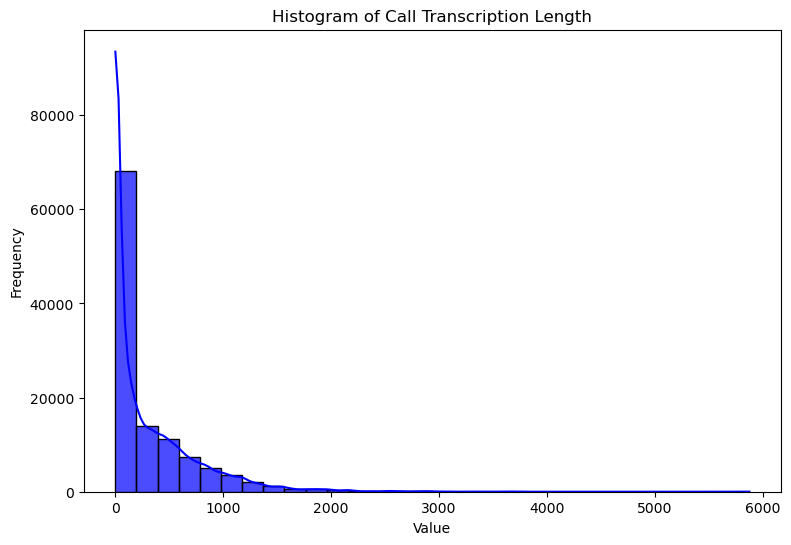

In [16]:
# Create histogram
plt.figure(figsize=(9, 6))
sns.histplot(data.length_call_transcription, bins=30, kde=True, color='blue', alpha=0.7)
plt.title('Histogram of Call Transcription Length')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [17]:
max_len = 1200
percent_large_transcript = np.round(
    (data.length_call_transcription > max_len).sum()*100/len(data),
    2
)
print(f"{percent_large_transcript}% of the calls have longer than {max_len} tokens.")

4.31% of the calls have longer than 1200 tokens.


# AWS Bedrock
---

In [18]:
client = boto3.client('bedrock')

response = client.list_foundation_models()
models = response['modelSummaries']
for model in models:
    print(f"Model name, id -> {bold_start}{model['modelName']}{bold_end},\t {model['modelId']}")

Model name, id -> Titan Text Embeddings V2,	 amazon.titan-embed-text-v2:0
Model name, id -> Claude 3.5 Sonnet,	 anthropic.claude-3-5-sonnet-20240620-v1:0
Model name, id -> Claude 3 Haiku,	 anthropic.claude-3-haiku-20240307-v1:0:200k
Model name, id -> Claude 3 Haiku,	 anthropic.claude-3-haiku-20240307-v1:0
Model name, id -> Llama 3.1 8B Instruct,	 meta.llama3-1-8b-instruct-v1:0:128k
Model name, id -> Llama 3.1 8B Instruct,	 meta.llama3-1-8b-instruct-v1:0
Model name, id -> Llama 3.1 70B Instruct,	 meta.llama3-1-70b-instruct-v1:0:128k
Model name, id -> Llama 3.1 70B Instruct,	 meta.llama3-1-70b-instruct-v1:0
Model name, id -> Llama 3.2 11B Instruct,	 meta.llama3-2-11b-instruct-v1:0
Model name, id -> Llama 3.2 90B Instruct,	 meta.llama3-2-90b-instruct-v1:0
Model name, id -> Llama 3.2 1B Instruct,	 meta.llama3-2-1b-instruct-v1:0
Model name, id -> Llama 3.2 3B Instruct,	 meta.llama3-2-3b-instruct-v1:0


## Mapping review with call
---

In [19]:
calldf = sfdf[sfdf.call_transcription.notnull()].reset_index()
print(len(calldf))
# calldf.sample(2)

22266


In [20]:
batch_size = 100

### Process saved call extracts
---

In [21]:
def clean_str_spch(
    df,
    cols=[],
    age_col='extract_age',
    exempt=[],
):
    """Remove special characters from a string."""
    df = df.copy(deep=True)
    if not cols:
        cols = df.select_dtypes(include=['object']).columns.tolist()
        cols = [col for col in cols if col not in exempt]
    
    for col in cols:
        df[col] = (
            df[col]
            .str.replace(':', '', regex=False)
            .str.replace('"', '', regex=False)
            .str.replace(',', '', regex=False)
            .str.replace('.', '', regex=False)
            .str.replace("'", '', regex=False)
            .str.strip()
        )
    if age_col in cols:
        df[age_col] = df[age_col].str.replace(r'\b(years?)\b', '', case=False, regex=True)
    return df

In [22]:
# Read the saved extract and process it into a DataFrame.
path_calls = 'calls_extract.csv'
calls_extract = pd.read_csv(path_calls)
calls_extract = calls_extract.set_index(['id'])
calls_extract.sample(2)

,call_extract
id,
a1aPf000000ni1yIAA,"Name: Peter Rose, DOB: '', Age: '', ID: ''."
a1aPf000000sMZzIAM,"Name: '', DOB: '', Age: '', ID: ''."


In [23]:
# Split on Name, DOB, Age and ID.
extract_name = calls_extract.loc[:, 'call_extract'].str.extract(r'(?i)name\s*(.*?)\s*dob')
extract_dob = calls_extract.loc[:, 'call_extract'].str.extract(r'(?i)dob\s*(.*?)\s*age')
extract_age = calls_extract.loc[:, 'call_extract'].str.extract(r'(?i)age\s*(.*?)\s*id')
extract_id = calls_extract.loc[:, 'call_extract'].str.extract(r'(?i)(?:\s*\n\s*|\b)\bid\b\s*(.*?)(?=\n)')

extractdf = pd.concat([extract_name, extract_dob, extract_age, extract_id, calls_extract], axis=1)
extractdf.columns = ['extract_name', 'extract_dob', 'extract_age', 'extract_id', 'calls_extract']
extractdf.sample(2)

,extract_name,extract_dob,extract_age,extract_id,calls_extract
id,,,,,
a1aPf000000kOyiIAE,": '',",": '',",": '',",NaN,"Name: '', DOB: '', Age: '', ID: ''."
a1aPf000000QawWIAS,": Mary Bartlett,",": 03/15/53,",": 33 years,",NaN,"Name: Mary Bartlett, DOB: 03/15/53, Age: 33 y..."


In [24]:
extractdf = extractdf.fillna('')
extractdf = clean_str_spch(extractdf, exempt=['calls_extract']).reset_index()
print(extractdf.shape)
extractdf.sample(2)

(18786, 6)


,id,extract_name,extract_dob,extract_age,extract_id,calls_extract
5043,a1aPf000000sL38IAE,,,,,"Name: '', DOB: '', Age: '', ID: ''."
4286,a1aPf000000oMVIIA2,Anna Morris,03/21/51,,,"Name: Anna Morris, DOB: 03/21/51, Age: '', ID..."


## Transcript
---

In [25]:
cleandf = sfdf[
    (sfdf.call_transcription.notnull()) & 
    (sfdf.call_end_time>=pd.to_datetime('2024-10-01')) &
    (sfdf.total_call_duration>=60)
]
cleandf.shape

(5350, 14)

In [26]:
batch_size = 10

### Read cleaned transcripts
---

In [27]:
def display_text(s):
    # Display the formatted text in a Jupyter Notebook
    if isinstance(s, str):
        return display(HTML(s.replace('\n', '<br>')))
    
    elif isinstance(s, pd.Series):
        return display(HTML(s.str.replace('\n', '<br>').str.cat(sep='<br>')))

In [28]:
# Read the saved extract and process it into a DataFrame.
path_calls = 'calls_cleaned.csv'
calls_cleaned = pd.read_csv(path_calls)
calls_cleaned.sample(2)

,id,call_cleaned
835,a1aPf000000tBMUIA2,Here is the cleaned-up call transcription:\n\...
1508,a1aPf000000rLs9IAE,Here is the cleaned-up call transcription:\n\...


In [45]:
calls_cleaned.shape

(2564, 2)

In [29]:
display_text(calls_cleaned[calls_cleaned.id=='a1aPf000000sQ5hIAE'].call_cleaned)

## P2P only notes - Delta
---

In [30]:
P2P_COLUMN = 'PeerToPeerReview'
SR_ID_COLUMN = 'sr_id'
DETERMINATIONNOTE_COLUMN = 'review_determinationnote'
RANK_COLUMN = 'commit'

sr = '65578029d986120001c7dd26'

In [31]:
cols = [
    'review_datecreated',
    'sr_id',
    'servicerequest_cohereid',
    'review_completedbyname',
    'review_reviewtype',
    'commit',
    'review_determinationnote',
    'review_decisionreasoning',
    'sr_datecreated',
]

In [32]:
def filter_rows(
    df,
):
    """Filter the DF for only the P2P service requests."""
    
    df = df.copy(deep=True)
    sr = (
        df[df.review_reviewtype==P2P_COLUMN]
        .drop_duplicates([SR_ID_COLUMN])
        [SR_ID_COLUMN]
    )
    df = df[df.sr_id.isin(sr)]

#     for sr_id, commit in commits.items():
#         new_rows = df[(df.sr_id==sr_id) & (df.commit.isin([commit, commit-1]))]
#         deltadf = pd.concat([deltadf, new_rows], ignore_index=True)
    
    return df

In [33]:
%%time
filterdf = filter_rows(reviewdf[cols])
filterdf = filterdf.sort_values(by=[SR_ID_COLUMN,RANK_COLUMN])
print(filterdf.shape)

(65263, 9)
CPU times: user 249 ms, sys: 15.7 ms, total: 265 ms
Wall time: 264 ms


In [34]:
reviewdf.review_datecreated.min()

Timestamp('2024-05-01 06:58:36')

In [35]:
reviewdf[reviewdf.sr_id=='660d6f7f3a7b6545b5d3f5fa']

,review_datecreated,review_datecompleted,sr_id,review_completedbyname,review_reviewtype,commit,review_reviewoutcome,review_determinationnote,review_decisionreasoning,laststate,nextstate,servicerequest_cohereid,review_id,sr_datecreated,commitdateinstant,servicerequest_clinicalservicename,servicerequest_encountertype,servicerequest_patientid,servicerequest_patient_coverage_healthplanname


In [36]:
filterdf[filterdf.sr_id=='660d6f7f3a7b6545b5d3f5fa']

,review_datecreated,sr_id,servicerequest_cohereid,review_completedbyname,review_reviewtype,commit,review_determinationnote,review_decisionreasoning,sr_datecreated


In [37]:
def str_cleanup(string):
    """
    The string contains a combination of multiple ':', '.', '\n' and ' '.
    It needs to be cleaned up for nltk's sent_tokenize to work well.
    """
    
    if isinstance(string, pd.Series):
        string = string.item()
    # Check if the input is a string
    if not isinstance(string, str):
        raise TypeError("Input sent to be cleaned must be a string.")
    
    # Exceptions for e.g., y.o., ...
    exception_lookahead = r'\b(?:g\.|o\.)'
    exception_lookbehind = r'\b(y\.o)'
    
    string = re.sub(
        # Negative lookbehind. 
        # Captures '.' and ':'.
        # Negative lookahead.
        r'(?<!' + exception_lookbehind + r')'
        r'([:.])\s*'
        r'(?!' + exception_lookahead + r')',
        r'\1\n',
        string
    )

    string = re.sub(r'\n+', '.', string)
    # Doubling the below function intentional.
    string = re.sub(r'\s*\.+\s*', '.', string)
    string = re.sub(r'\s+', ' ', string).strip()
    string = re.sub(r'\s*\.+\s*', '. ', string).strip()    
    return string

In [38]:
seq_new=filterdf[filterdf.sr_id=='663229a8ad04c268b0836382']['review_determinationnote'].iloc[3]
seq_old=filterdf[filterdf.sr_id=='663229a8ad04c268b0836382']['review_determinationnote'].iloc[2]

In [39]:
str_cleanup(seq_new)

'Clinical Summary. Chief complaint, duration, severity. 72 y. o. female who reports nonhealing wound on the right heel. Has had wound debridement and skin grafting, no wound care notes provided. PMH. PVD. CAD s/p CABG. HTN. HLD. Treatments attempted duration. Meds. Atorvastatin, ASA. Pertinent imaging findings. LEAD 4/29/24. R ABI. is 0. 68, R TBI. is 0. 33. Hemodynamically significant stenosis visualized in the right proximal SFA with peak systolic velocity 496cm. right mid SFA with peak systolic velocity 198 cm/s. Monophasic waveforms seen in the right popliteal, posterior tibial, and anterior tibial arteries. The right peroneal artery appears occluded. Plan of care. RLE intervention Femoral-Popliteal 37224, Vein Angioplasty/Stent 37238P2P Discussion with. Angie McCaffrey-Lazo, MD, 5/8/2024Decision Explanation. Withdraw 37228 she agrees, this is not needed. 37224 approved.'

In [40]:
seq_new

'Clinical Summary:Chief complaint, duration, severity: 72 y.o. female who reports nonhealing wound on the right heel. Has had wound debridement and skin grafting, no wound care notes provided.PMH:  \n \n    PVD  \n    CAD s/p CABG  \n    HTN  \n    HLD  \n \n  Treatments attempted   duration:   \n \n    Meds: Atorvastatin, ASA  \n \n  Pertinent imaging findings:  \n \n    LEAD 4/29/24: R ABI: is 0.68, R TBI: is 0.33. Hemodynamically significant stenosis visualized in the right proximal SFA with peak systolic velocity 496cm. right mid SFA with peak systolic velocity 198 cm/s. Monophasic waveforms seen in the right popliteal, posterior tibial, and anterior tibial arteries. The right peroneal artery appears occluded.  \n \n  Plan of care: RLE intervention Femoral-Popliteal 37224, Vein Angioplasty/Stent 37238P2P Discussion with:  Angie McCaffrey-Lazo, MD, 5/8/2024Decision Explanation: Withdraw 37228 she agrees, this is not needed.  37224 approved.'

In [41]:
cleandf

,agent_name,call_start_time,call_end_time,total_call_duration,call_transcription,call_id,agent_talk_time,handle_time,after_call_work_time,hold_time,automation_time,local_date,service_name,time_zone
0,Sylvia Allwardt,2024-11-20 14:12:43,2024-11-20 14:22:49,606.00,Thank you for calling schnect surgical associa...,a1aPf000000xxnxIAA,602.00,636.00,32.00,0.00,0.00,2024-11-20,Outbound Call,America/New_York
1,Marshall Trusler,2024-11-08 09:35:13,2024-11-08 09:36:17,65.00,"Hi, this is step saw, the physician assistant ...",a1aPf000000vwYHIAY,42.00,70.00,7.00,0.00,0.00,2024-11-08,Outbound Call,America/New_York
3,reena desai,2024-11-07 14:03:02,2024-11-07 14:06:34,212.00,"Sada general surgery? This is Chris. Hi, this ...",a1aPf000000vmwZIAQ,207.00,242.00,31.00,0.00,0.00,2024-11-07,Outbound Call,America/New_York
4,Marvin Friedlander,2024-11-08 10:23:09,2024-11-08 10:26:56,227.00,"Hey, it's erin. Come around so sorry I missed ...",a1aPf000000vx3IIAQ,220.00,256.00,31.00,0.00,0.00,2024-11-08,Outbound Call,America/New_York
5,Marvin Friedlander,2024-11-19 15:50:59,2024-11-19 15:52:06,67.00,Your call has been forwarded to voicemail. The...,a1aPf000000xnScIAI,44.00,97.00,31.00,0.00,0.00,2024-11-19,Outbound Call,America/New_York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29905,Senthil Sundaram,2024-10-29 11:10:31,2024-10-29 11:16:26,355.00,Thank you for calling advent health medical gr...,a1aPf000000uAurIAE,344.00,377.00,31.00,0.00,0.00,2024-10-29,Outbound Call,America/New_York
29906,Teddrick Dunson,2024-10-29 13:45:25,2024-10-29 13:47:18,112.00,"Hello? Hi Ms. Speak with skyler Davis, please....",a1aPf000000uDxDIAU,105.00,142.00,31.00,0.00,0.00,2024-10-29,Outbound Call,America/New_York
29908,Amita Dharawat,2024-10-31 09:58:36,2024-10-31 10:02:25,229.00,Hello. Thank you for calling our health medica...,a1aPf000000uZ5MIAU,224.00,258.00,31.00,0.00,0.00,2024-10-31,Outbound Call,America/New_York
29909,Sylvia Allwardt,2024-10-31 10:49:55,2024-10-31 11:02:43,768.00,Thank you for calling willis night and robotic...,a1aPf000000uZk4IAE,758.00,798.00,31.00,0.00,0.00,2024-10-31,Outbound Call,America/New_York


In [42]:
def seq_delta(string1, string2):
    """
    Take 2 sequences and find the delta by sentence level.
    """
    sent = []        
    
    string1 = str_cleanup(string1)
    string2 = str_cleanup(string2)
    # FuzzyWuzzy simple ratio difference.
    diff = fuzz.ratio(string2, string1)
    
    # Tokenize the strings into sentences.
    sequence1 = sent_tokenize(string1)
    sequence2 = sent_tokenize(string2)
    
                    
    # The first line might be a copy paste without '\n'.
    sent1 = []
    if sequence1 and sequence1 and fuzz.ratio(sequence1[0], sequence2[0])!=100 and fuzz.partial_ratio(sequence1[0], sequence2[0])==100:
        for word in sequence2[0].split():
            if word not in sequence1[0].split():
                sent1.append(word)
        sequence2[0] = " ".join(sent1)
        
    # Find new sentences in string.
    # Sets are unordered, so maintain order through a list.
    for sequence in sequence2:
        if sequence not in set(sequence1):
            sent.append(sequence)
                
    # Output the new sentences.
    return sent, diff

In [43]:
def fn(df, col, commit):
    df = df.copy(deep=True)
    
    df[f'{commit}1'] = df.commit + 1

    mergedf = pd.merge(
        df, 
        df, 
        left_on=['sr_id', commit], 
        right_on=['sr_id', f'{commit}1'], 
        suffixes=('', '_1'), 
        how='left'
    )
    mergedf = mergedf[mergedf.review_reviewtype==P2P_COLUMN]
    
    for index, row in mergedf.iloc[1:].iterrows():
        try:
            delta, diff = seq_delta(row[f'{col}_1'], row[col])
            delta = ' \n'.join(s.strip() for s in delta).strip()
            return delta

            mergedf = mergedf.reset_index()[df.columns]
            mergedf[f'{col}_cleaned'], mergedf[f'{col}_diff'] = delta, diff
        
        except Exception as e:
            print(f"Error processing index {index}: {e}")
            print(row)
            return mergedf
    
    return mergedf

In [44]:
delta, diff = seq_delta(seq1,seq2)
delta

NameError: name 'seq1' is not defined

In [ ]:
display_text(' \n'.join(s.strip() for s in delta).strip())

In [ ]:
sections_seq = [
    "Clinical Summary",
    "Plan of care",
    "P2P Discussion with",
    "Decision Explanation",
]
sections_seq

In [ ]:
%%time
cleandf = fn(filterdf.iloc[:100], DETERMINATIONNOTE_COLUMN, RANK_COLUMN)

In [ ]:
cleandf

In [ ]:
%%time
bedrock_runtime = boto3.client(service_name="bedrock-runtime", region_name='us-east-1')
modelid = "anthropic.claude-instant-v1"

prompt_start = f"""Human:
Punctuations cleanup. P2P is a separate word.
'Clinical Summary:Chief complaint, duration, severity: 72 y. o. female who reports nonhealing wound on the right heel.',
 'Plan of care: RLE intervention Femoral-Popliteal 37224, Vein Angioplasty/Stent 37238P2P Discussion with: Angie McCaffrey-Lazo, MD, 5/8/2024Decision Explanation: Withdraw 37228 she agrees, this is not needed.',
 '37224 approved.'
"""

prompt = f"""{prompt_start}
Assistant:
"""
response = bedrock_runtime.invoke_model(
    modelId=modelid,
    contentType="application/json",
    accept="application/json",
    body=json.dumps({
        "prompt": prompt,
        "max_tokens_to_sample": 6000,
        "temperature": 0.7,
        "top_p": 0.9,
        "top_k": 50,
    })
)

response_body = json.loads(response['body'].read())
call_cleaned = response_body.get('completion', 'No response')
print(call_cleaned)

In [ ]:
def add_newline_before_sections():
    return 0

## Text Cleanup
---

In [ ]:
text = """
It's a great day at Cohere. My name is Martina, I have your full name and phone number, please.
Hi, my name is susan.
Thank you, miss susan.
And last initial is? I'm sorry, last initial is Eight.
Ok, thank you, miss susan. And may I also have a good phone number, our call back number for you?
864-512-4526.
Ok. And just to verify that was 864-512-4526. Is that correct?
That is correct.
Ok. And which health plan are you calling in reference to Today?
Humana?
And are you calling on behalf of the ordering or performing provider?
The ordering and performing.
Ok. And also just to verify yes, ma'am.
And let me just tell you right quick before let me tell you right quick while I'm calling. Before we go on, my doctor did appear, appear Yesterday with One of your docs and the doctor that he did the peer to peer with, denied, One of my procedure codes but he approved the other Two now in the website on the website it got that y'all have someone has with, drown it and I need the.
I need the authorization number for the Two code that he approved. But somebody had I got, like I said withdrawn it.
Ok. Could you provide me with the tracking number you're calling in reference to?
Yes, ma'am, I can it is R as in randy, T as in tony, I as in igloo, C as in Charlie lost thing 8773?
Ok. And just to verify that was R, T, I, C 8773. Correct?
That is great.
And could you verify the member's name and date of birth?
It is Carl rollins 10 27 55.
Ok.
Bear, bear with me. One moment. Let me review the notes on the account, ok?
Yes, ma'am, ok.
Ok, bear with me One moment. I'm still here, so that was 936-539-3656.
Yes, ma'am?
Ok, I just want to make sure so it looks like with the
He?
Ok, so for the Two C, P, T codes that were able to be approved, the 936-569-3653. For that one code that could not be approved, a new authorization had to be submitted, so that was submitted, and it is approved. If you would like, I can provide you with the uten Tracking ID number, so the withdrawn case yes, ma'am. That withdrawn case is due to that One code that could not be approved, so the new Tracking ID. I'm sorry. The new option number is 195-370-999.
That would be great, ok?
Again, that was 195-370-999. And if you would like that Tracking ID number as well is G T, A, R 1391, so G T A R 1391.
Ok.
And the dates of services 86 of 24 until 96 24 for C, P, C code 936-569-3653.
Ok.
So when I go in here and look at my at the?
The website? Should I not be able to see that?
Yes, ma'am you?
Sometimes, if you are not the person, yes, ma'am, the one that was previously withdrawn. That's the one you're able to see correct. Sometimes, if you are not the person that submitted the authorization via the portal, you would need to look it up by clicking on start authorquest and entering the members, I, D and date of birth, and then click on patient summary.
Cuz, I've seen the one where that seen it.
Go ahead, I'm sorry.
Yeah.
Yeah, and I am. I am the yeah, I'm sorry. I am the one that I'm sorry. I am the one that did the authorization, I did it. And I can see you know the withdraw one and because I did do it myself and I actually went in there. And the old one, the one that was withdrawn. I went in there and tried to remove the 33340 so I could, you know would be able to use that. But then I seen the the withdrawn thing but does it take it little while for it to upload or because I'm still not seeing it?
Ok.
No ma'am, who no ma'am, whoever updated the authorization due to that C, P, T code not being able to be removed from the request. The reason you're not able to see it is because a new submission was done so like I said, it was submitted by us on our end. So, with it being resubmitted and a new authorization being submitted, you would click on start a request to answer the members, I, D, and date of birth, to pull up the patients to view all of the authorizations that the member has on file, versus just the ones that you submitted. To see the one that I'm referencing to.
Ok, so that's usually a place that I can put the new tracking number in as well. Where would I do that? Because, I usually can.
Yes, ma'am on the dashboard. If you enter it on the dashboard, it may pull up just in the event that it doesn't, you would need to do it. The additional way, start a request to answer the I D and date of birth, but you can try enter it on the dashboard. Click on Cohere health, and that'll take you back to the dashboard and in that search bar, inter that Tracking ID number that was provided.
Ok, I can right there. Ok. Thank you so much for your help, marcia, and you have a wonderful rest of your Day.
You're more than welcome, and just to verify if there anything else I can assist you with Today.
No, ma'am. I thank you for all of your help.
You're welcome, and thank you for calling Cohere help you. Have a great day if there's nothing more than I can assist you with?
You as well. Bye bye.
Bye, bye.
"""

In [ ]:
%%time
bedrock_runtime = boto3.client(service_name="bedrock-runtime", region_name='us-east-1')
modelid = "anthropic.claude-instant-v1"

prompt_start = f"""Human:
Clean this up.
"""

prompt = f"""{prompt_start}
{text}
Assistant:
"""
response = bedrock_runtime.invoke_model(
    modelId=modelid,
    contentType="application/json",
    accept="application/json",
    body=json.dumps({
        "prompt": prompt,
        "max_tokens_to_sample": 6000,
        "temperature": 0.7,
        "top_p": 0.9,
        "top_k": 50,
    })
)

response_body = json.loads(response['body'].read())
call_cleaned = response_body.get('completion', 'No response')
print(call_cleaned)

## Write to S3 bucket
---

In [ ]:
# Define S3 bucket name and object name
s3_uri = 's3://tf-cohere-health-team-intelligent-prior-auth/users/ruthranc/'
bucket_name = 'tf-cohere-health-team-intelligent-prior-auth'
s3_file_path = 'users/ruthranc/p2p_hum2024_bedrock.csv'

# Initialize S3 client
s3_client = boto3.client('s3')

# Upload the CSV file
s3_client.upload_file(csv_file_path, bucket_name, s3_file_path)

print(f'Successfully uploaded {csv_file_path} to s3://{bucket_name}/{s3_file_path}')

In [ ]:
import sagemaker
from sagemaker.processing import ScriptProcessor
from sagemaker import get_execution_role

# Step 1: Set up your SageMaker session and role
sagemaker_session = sagemaker.Session()
role = get_execution_role()  # Ensure you have the appropriate permissions

# Step 2: Define your processing script
# Assume 'process_data.py' is your script that processes the data
script_name = 'process_data.py'

# Step 3: Define the ScriptProcessor
script_processor = ScriptProcessor(
    role=role,
    image_uri='your-processing-image',  # Specify your Docker image URI
    command=['python3'],
    instance_count=1,
    instance_type='ml.m5.large',  # Choose an appropriate instance type
    sagemaker_session=sagemaker_session,
)

# Step 4: Define input and output
inputs = 's3://your-bucket/path/to/input/data'  # Input data location
outputs = 's3://your-bucket/path/to/output/data'  # Output data location

# Step 5: Run the Processing Job
script_processor.run(
    code=script_name,
    inputs=[sagemaker.inputs.TrainingInput(s3_data=inputs, content_type='text/csv')],
    outputs=[sagemaker.inputs.TrainingInput(s3_data=outputs)],
    arguments=['--arg1', 'value1', '--arg2', 'value2'],  # Additional arguments for your script
)

print("Processing job submitted!")